In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler
from joblib import dump

In [3]:
df = pd.read_csv("C:/Users/Angel/Documents/Data/vehicles.csv")

### Data Cleaning / Preprocessing To-Do List

1. **Handle Missing Values**:
   - [⏳] Identify missing values in the dataset.
   - [⏳] Decide on an imputation strategy.
   - [⏳] Apply the chosen method to handle missing data.

2. **Outlier Detection and Treatment**:
   - [ ] Identify outliers in the numeric features using statistical methods (IQR, Z-score) or visualizations (boxplots).
   - [ ] Decide on a treatment strategy (remove, cap/floor, or transform) for outliers.
   - [ ] Apply the chosen strategy.

3. **Feature Encoding**:
   - [ ] Identify categorical features that need encoding.
   - [ ] Apply one-hot encoding for nominal categories with no inherent order.
   - [ ] Apply label encoding for ordinal categories with a clear order.
   - [ ] Consider frequency or target encoding for high-cardinality categorical features.

In [4]:
# These are the columns that, no matter it´s content, we can drop them, may need to drop others later.
useless_columns = ["id", "url", "region_url","image_url", "description", "county", "lat", "long", "posting_date", "VIN"]
df.drop(useless_columns, axis = 1, inplace = True)

In [5]:
# This function returns a Series that contains the percentage of missing values for each feature.
def percent_missing(df):
    sorted_sum = df.isna().sum().sort_values(ascending = True)/len(df)
    sorted_sum = sorted_sum[sorted_sum > 0].sort_values()
    return sorted_sum

def generate_missplot(df):
    missing_values = percent_missing(df)
    sns.barplot(x = missing_values.index, y = missing_values)
    plt.xticks(rotation = 90);
    plt.xlabel("Feature")
    plt.ylabel("Percentage")

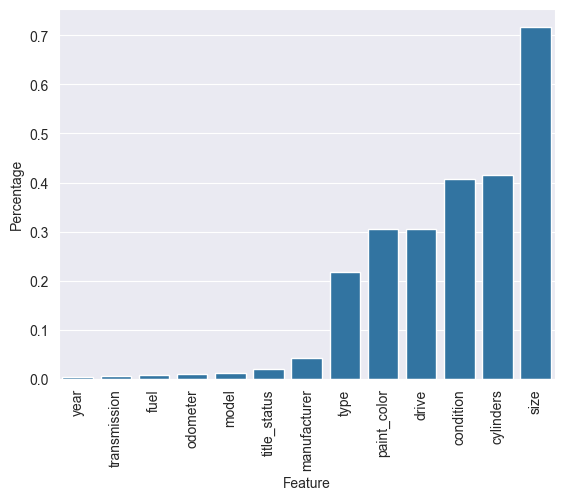

In [6]:
# This barplot shows the necessity of dealing with the missing values, otherwise it may jeopardize ou ML model.
generate_missplot(df)

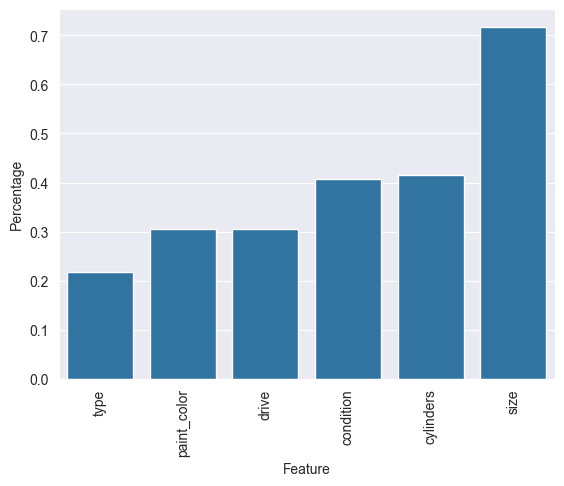

In [7]:
# Let´s deal with the columns with low number of missing values.
missing_values = percent_missing(df)
filtered_columns = missing_values[missing_values < 0.1].index

for column in filtered_columns:
    if df[column].dtype != "object":
        df[column] = df[column].fillna(df[column].mean())
    else:
        df[column] = df[column].fillna("NTP")

# We can already see a decreasce in the number of missing values.
generate_missplot(df)

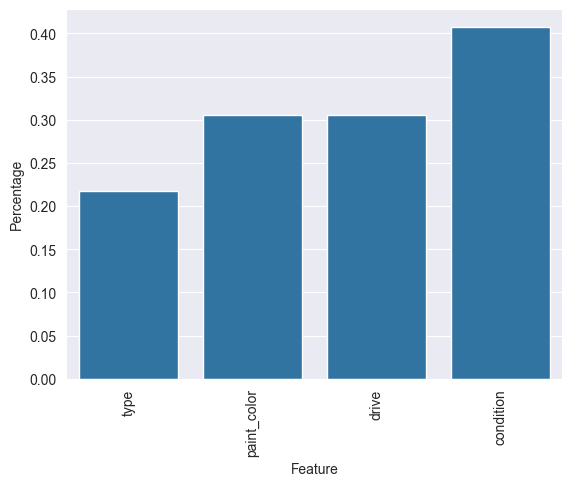

In [8]:
# Since the "size" column has way too many null values, we can just drop it.
df = df.drop("size", axis = 1)

# For the "cylinders" column, I will use an auxiliar column to deal with it.
df['cylinders'] = df['cylinders'].fillna('place_holder')
df['cylinders_num'] = df['cylinders'].str.extract('(\d+)')
df['cylinders_num'] = df['cylinders_num'].astype(float)
df['cylinders'] = df['cylinders_num'].fillna(df["cylinders_num"].mean()).astype(int)

# Removing the auxiliar column
df.drop("cylinders_num", axis=1, inplace=True)

generate_missplot(df)

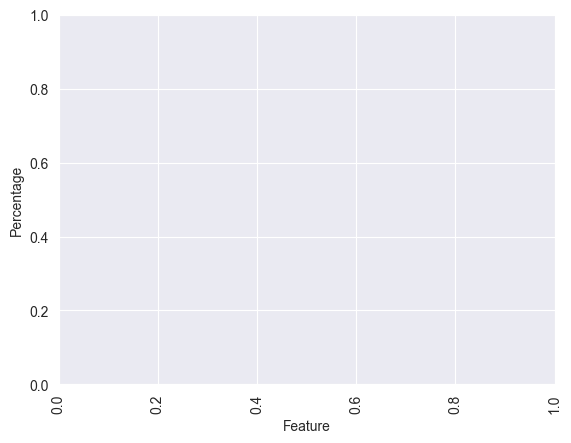

In [9]:
# Finally, we will just fill the rest with NTP, since there is no great domain prediction we can make.
last_columns = list(percent_missing(df).index)
df[last_columns] = df[last_columns].fillna("NTP")

generate_missplot(df)

### Data Cleaning / Preprocessing To-Do List

1. **Handle Missing Values**:
   - [✔️] Identify missing values in the dataset.
   - [✔️] Decide on an imputation strategy.
   - [✔️] Apply the chosen method to handle missing data.

2. **Outlier Detection and Treatment**:
   - [⏳] Identify outliers in the numeric features using statistical methods (IQR, Z-score) or visualizations (boxplots).
   - [⏳] Decide on a treatment strategy (remove, cap/floor, or transform) for outliers.
   - [⏳] Apply the chosen strategy.

3. **Feature Encoding**:
   - [ ] Identify categorical features that need encoding.
   - [ ] Apply one-hot encoding for nominal categories with no inherent order.
   - [ ] Apply label encoding for ordinal categories with a clear order.
   - [ ] Consider frequency or target encoding for high-cardinality categorical features.


Text(0.5, 1.0, 'Sem Outliers')

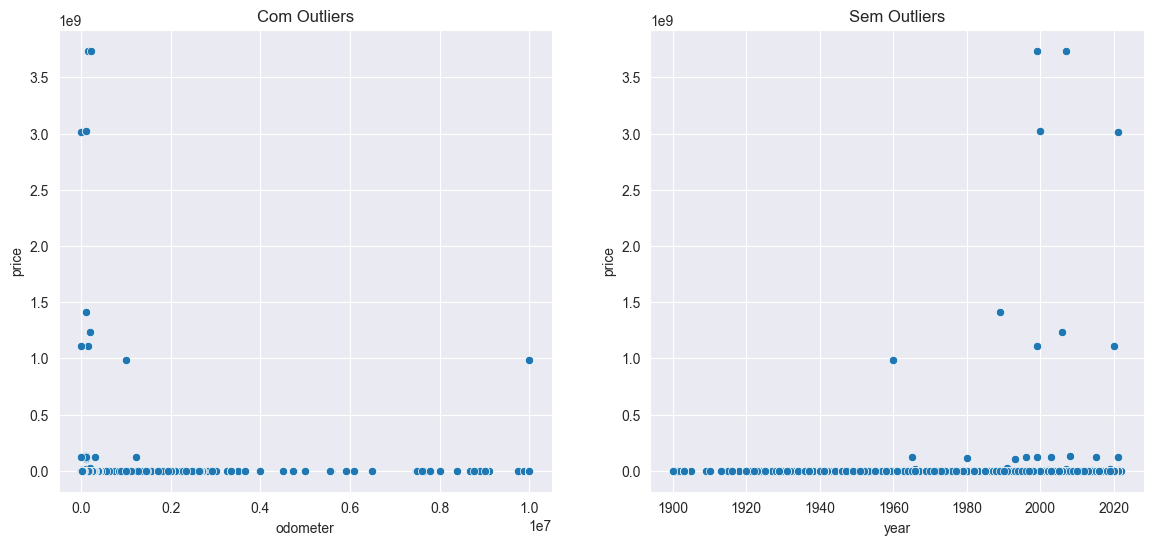

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x="odometer", y="price", data=df, ax=ax1)
ax1.set_title('Com Outliers')

sns.scatterplot(x="year", y="price", data=df, ax=ax2)
ax2.set_title('Sem Outliers')

In [11]:
# I could do this with an lower_limit too, but I tested and it didn´t work well (having negative lower limits).
def upper_remover(df,column):
    q25, q75 = np.percentile(df[column], [25, 75])
    iqr = q75 - q25
    upper_limit = q75 + 1.5 * iqr

    df = df[(df[column] < upper_limit)]
    print(f"upper_Limit for {column}: {upper_limit}")
    return df

In [12]:
# With this we set upper limits for price and odometer.
df = upper_remover(df,"price")
df = upper_remover(df,"odometer")

# While also setting lower limits for price and year.
df = df[df["price"] > 6000]
df = df[df["year"] > 1980]

upper_Limit for price: 57364.375
upper_Limit for odometer: 275529.5


Text(0.5, 1.0, 'Sem Outliers')

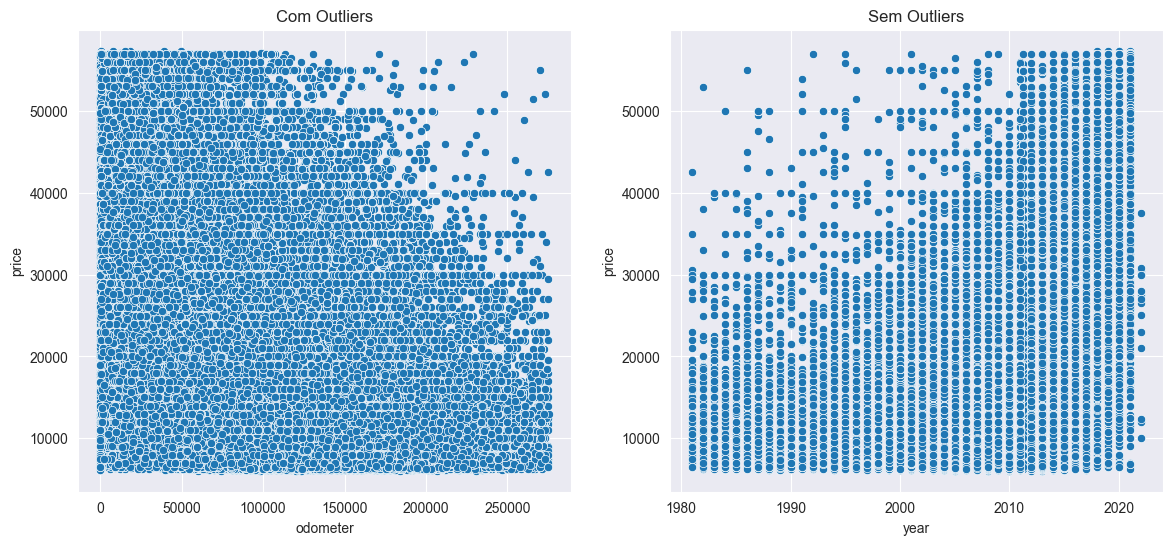

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x="odometer", y="price", data=df, ax=ax1)
ax1.set_title('Com Outliers')

sns.scatterplot(x="year", y="price", data=df, ax=ax2)
ax2.set_title('Sem Outliers')

### Data Cleaning / Preprocessing To-Do List

1. **Handle Missing Values**:
   - [✔️] Identify missing values in the dataset.
   - [✔️] Decide on an imputation strategy.
   - [✔️] Apply the chosen method to handle missing data.

2. **Outlier Detection and Treatment**:
   - [✔️] Identify outliers in the numeric features using statistical methods (IQR, Z-score) or visualizations (boxplots).
   - [✔️] Decide on a treatment strategy (remove, cap/floor, or transform) for outliers.
   - [✔️] Apply the chosen strategy.

3. **Feature Encoding**:
   - [⏳] Identify categorical features that need encoding.
   - [⏳] Apply one-hot encoding for nominal categories with no inherent order.
   - [⏳] Apply label encoding for ordinal categories with a clear order.
   - [⏳] Consider frequency or target encoding for high-cardinality categorical features.

In [14]:
# Since creating dummies in this case would de be really costy, I opted for using Label Encoding.
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Appending all the not numerical columns into to a list.
categorical_columns = []
features = df.columns.values.tolist()
for col in features:
    if df[col].dtype in numerics: continue
    categorical_columns.append(col)

# Applying LabelEncoder to each categorical column, LabelEncoder converts categorical labels into a numerical format.
for col in categorical_columns:
    if col in df.columns:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

In [15]:
# Normalizing the data with an reasonable range
df['year'] = (df['year']-1900).astype(int)
df['odometer'] = df['odometer'].astype(int)

### Trees Regressor To-Do List

1. **Preprocessing**:
   - [⏳] Select features and target.
   - [⏳] Apply `PolynomialFeatures` and `StandardScaler`.
   - [⏳] Split data into training and testing sets.

2. **Model Training**:
   - [⏳] Fit an initial `ExtraTreesRegressor` model.

3. **Model Tuning**:
   - [ ] Define and use a parameter grid with `GridSearchCV`.
   - [ ] Find the best parameters and model.

4. **Model Evaluation**:
   - [ ] Predict using the best model.
   - [ ] Print model score and RMSE.
   - [ ] Create and review a comparison DataFrame of actual vs. predicted values.

In [18]:
# Selecting our features and target
x = df.drop("price", axis = 1)
y = df["price"]

# Using PolynomialFeatures to ensure that we also train the model with the interactions between the features.
poly = PolynomialFeatures(degree = 2)
x_poly = poly.fit_transform(x)

# Using a scaler to normalize the data.
scaler = StandardScaler()
x_poly = scaler.fit_transform(x_poly)

# Spliting
x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.2, random_state=101)

ExtraTreesRegressor()

### Trees Regressor To-Do List

1. **Preprocessing**:
   - [✔️] Select features and target.
   - [✔️] Apply `PolynomialFeatures` and `StandardScaler`.
   - [✔️] Split data into training and testing sets.

2. **Model Training**:
   - [✔️] Fit an initial `ExtraTreesRegressor` model.

3. **Model Tuning**:
   - [⏳] Define and use a parameter grid with `GridSearchCV`.
   - [⏳] Find the best parameters and model.

4. **Model Evaluation**:
   - [ ] Predict using the best model.
   - [ ] Print model score and RMSE.
   - [ ] Create and review a comparison DataFrame of actual vs. predicted values.

In [28]:
# Tuning our model, so it gets the best parameters
etr = ExtraTreesRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=etr, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Fitting 2 folds for each of 324 candidates, totalling 648 fits


C:\Users\Angel\PycharmProjects\pythonProject3\venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
216 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Angel\PycharmProjects\pythonProject3\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Angel\PycharmProjects\pythonProject3\venv\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\Angel\PycharmProjects\pythonProject3\venv\lib\site-packages\sklearn\base.py", line 666, 

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Trees Regressor To-Do List

1. **Preprocessing**:
   - [✔️] Select features and target.
   - [✔️] Apply `PolynomialFeatures` and `StandardScaler`.
   - [✔️] Split data into training and testing sets.

2. **Model Training**:
   - [✔️] Fit an initial `ExtraTreesRegressor` model.

3. **Model Tuning**:
   - [✔️] Define and use a parameter grid with `GridSearchCV`.
   - [✔️] Find the best parameters and model.

4. **Model Evaluation**:
   - [⏳] Predict using the best model.
   - [⏳] Print model score and RMSE.
   - [⏳] Create and review a comparison DataFrame of actual vs. predicted values.

In [55]:
# Extre Tree Regressor with most optimized parameters
etr = ExtraTreesRegressor(max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=200, n_jobs=-1)

cv_scores = cross_val_score(etr, x_poly, y, cv=10, scoring='r2')
print(f"Cross-Validated R^2: {round(cv_scores.mean(), 3)}")

etr.fit(x_train, y_train)
y_pred = etr.predict(x_test)

rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

# Print metrics
print(f"Root Mean Squared Error: {round(rmse, 3)}")
print(f"Mean Absolute Error: {round(mae, 3)}")
print(f"Explained Variance Score: {round(explained_variance, 3)}")

comparison_df1 = pd.DataFrame({
    'Actual Performance': y_test.values.flatten(),
    'Predicted Performance': y_pred.flatten()
})
comparison_df1["diff"] = comparison_df1["Actual Performance"] - comparison_df1["Predicted Performance"]

comparison_df1

Cross-Validated R^2: 0.867
Root Mean Squared Error: 3214.571
Mean Absolute Error: 1637.678
Explained Variance Score: 0.924


,Actual Performance,Predicted Performance,diff
0,9990,10052.7250,-62.7250
1,30990,31129.0000,-139.0000
2,27990,27990.0000,0.0000
3,23995,23995.0000,0.0000
4,9962,9962.0000,0.0000
...,...,...,...
59276,11268,14434.3675,-3166.3675
59277,17989,20205.3900,-2216.3900
59278,20000,20766.9775,-766.9775
59279,7700,7900.0000,-200.0000


In [ ]:
# Saving the ETR model to a file
dump(etr, 'extra_trees_model.joblib')